# Data Pre-Processing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", 100)
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [3]:
df.shape

(2240, 29)

## Data Cleaning

#### Check Null Values

In [4]:
features_with_na=[features for features in df.columns if df[features].isnull().sum()]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Income 1.07143 % missing values


In [5]:
df[features_with_na].select_dtypes(exclude='object').describe()

Income
count    2216.000000
mean    52247.251354
std     25173.076661
min      1730.000000
25%     35303.000000
50%     51381.500000
75%     68522.000000
max    666666.000000

### Imputing Null values
* Impute Median value for Income column

In [6]:
df.Income.fillna(df.Income.median(), inplace=True)

**Handling Duplicates**

In [7]:
df.duplicated().sum()

np.int64(0)

* Remove ```ID``` column because that is not going to participate in model building task.
* Remove ```Z_CostContact``` and ```Z_Revenue``` columns as contains only constant value, therefore doesn't create any variance in the dataset.

In [8]:
columns_to_drop = ['ID', 'Z_CostContact','Z_Revenue']
for column in columns_to_drop:
    df.drop(column, inplace=True, axis=1)
    print(f"Column {column} is dropped.")

Column ID is dropped.
Column Z_CostContact is dropped.
Column Z_Revenue is dropped.


## Feature Extraction
- We will extract and create some of the meaningfull features.

In [9]:
from datetime import datetime

raw_df = df.copy() #saving the raw dataframe for reference


# creating a new field to store the Age of the customer
df['Age']=2025-df['Year_Birth']   

# recoding the customer's education level to numeric form (0: basic, 1: 2n cycle, 2: graduation, 3: masters, and 4: phd)
df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)  

# recoding the customer's marital status to numeric form (0: not living with a partner, 1: living with a partner) 
df['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0},inplace=True) 

# creating a new field to store the number of children in the household
df['Children']=df['Kidhome']+df['Teenhome']

# creating Family_Size
df['Family_Size']=df['Marital_Status']+df['Children']+1



# creating a new field to store the total spending of the customer
df['Total_Spending']=df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
df["Total Promo"]=df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"]

# The following code works out how long the customer has been with the company and store the total number of promotions the customers responded to
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
today=datetime.today()
df['Days_as_Customer']=(today-df['Dt_Customer']).dt.days
df['Offers_Responded_To']=df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']
df["Parental Status"] = np.where(df["Children"] > 0, 1, 0)



# dropping columns which are already used to create new features
columns_to_drop = ['Year_Birth','Kidhome','Teenhome']
df.drop(columns = columns_to_drop, axis = 1, inplace=True)
df.rename(columns={"Marital_Status": "Marital Status",
                   "MntWines": "Wines",
                   "MntFruits": "Fruits",
                   "MntMeatProducts": "Meat",
                   "MntFishProducts": "Fish",
                   "MntSweetProducts": "Sweets",
                   "MntGoldProds": "Gold",
                   "NumWebPurchases": "Web",
                   "NumCatalogPurchases": "Catalog",
                   "NumStorePurchases": "Store",
                   "NumDealsPurchases": "Discount Purchases"},
          inplace = True)

df = df[["Age","Education","Marital Status","Parental Status","Children","Income","Total_Spending","Days_as_Customer","Recency","Wines","Fruits","Meat","Fish","Sweets","Gold","Web","Catalog","Store","Discount Purchases","Total Promo","NumWebVisitsMonth"]]


### Type of Features

**Numeric Features**

In [10]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Number of Numerical Features: ', len(num_features))

Number of Numerical Features:  21


**Categorical Features**

In [11]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Number of Categorical Features :', len(cat_features))

Number of Categorical Features : 0


**Discrete Features**

In [12]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Number of Discrete Features :',len(discrete_features))

Number of Discrete Features : 10


**Continuous Features**

In [13]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Number of Continuous Features: ',len(continuous_features))

Number of Continuous Features:  11


In [14]:
continuous_features

['Age',
 'Income',
 'Total_Spending',
 'Days_as_Customer',
 'Recency',
 'Wines',
 'Fruits',
 'Meat',
 'Fish',
 'Sweets',
 'Gold']

## Outliers Detection

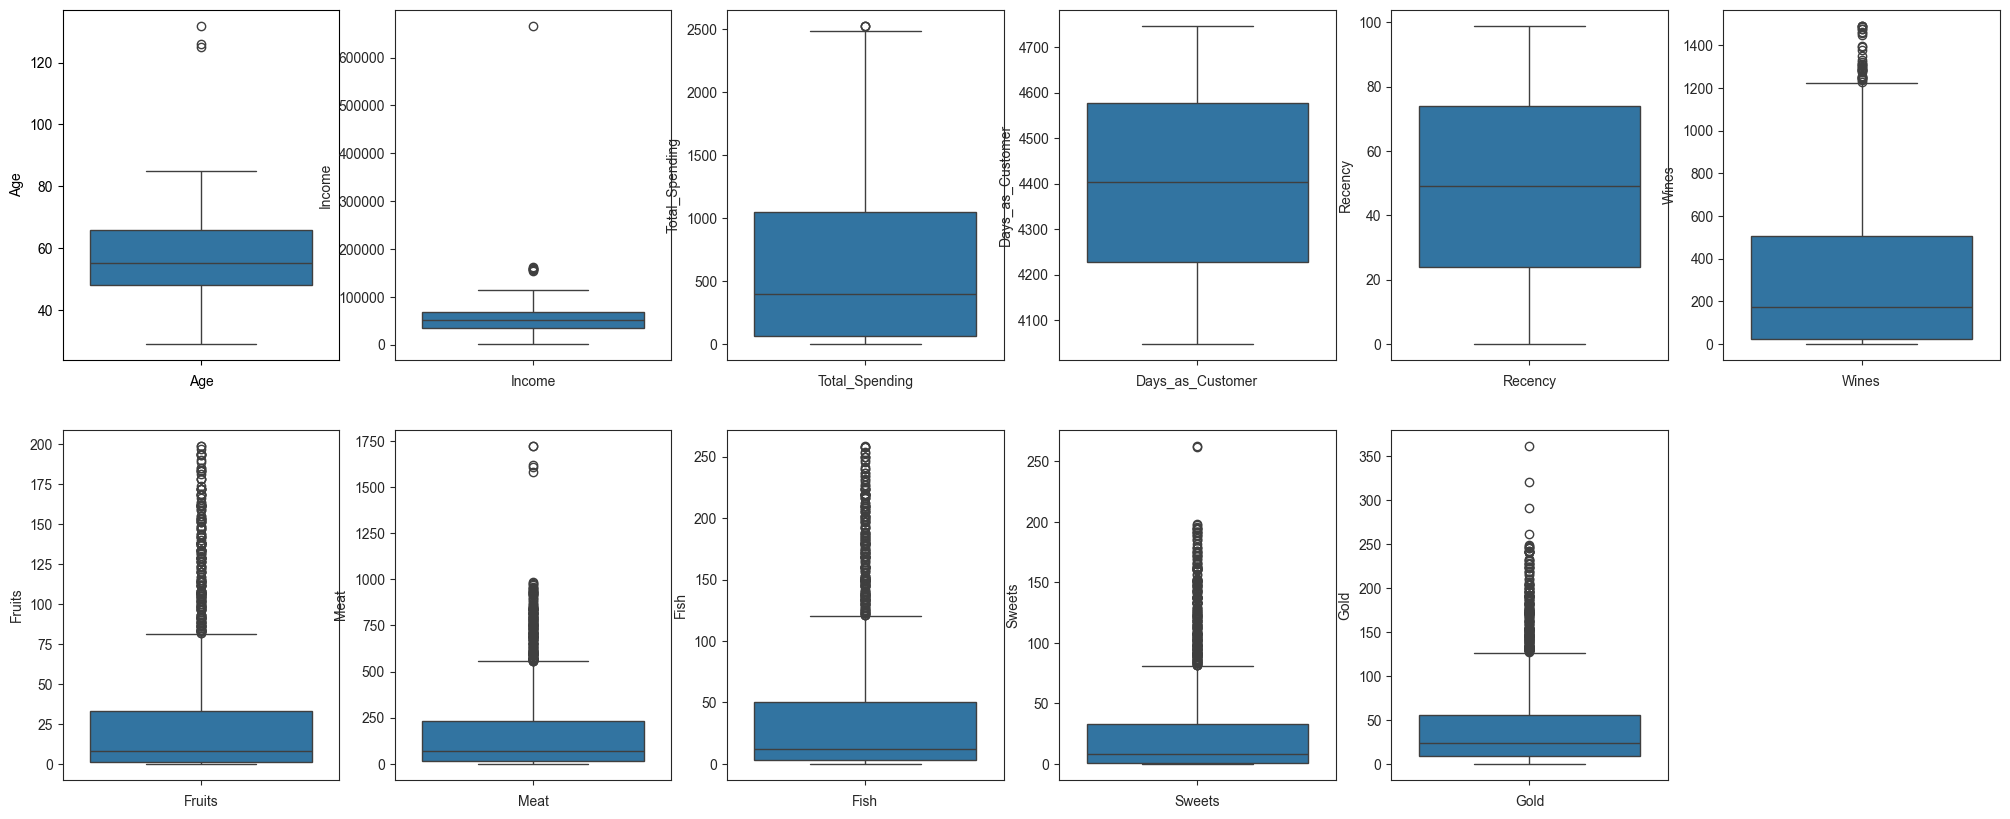

In [15]:
cont_features = continuous_features.copy()
plt.figure(figsize=(25, 10))

for i in range(len(cont_features)):
        plt.subplot(2,6,i+1)
        sns.set_style('ticks')
        plt.xlabel(cont_features[i])
        ax = sns.boxplot(df[cont_features[i]])

- We can see, there are no such outliers in ```Recency``` and ```Days_as_Customer``` Column
- But there are outliers in ```Income```, ```Wines```, ```Fruits```, ```Meat```, ```Fish```, ```Sweets```, ```Gold```, ```Age``` and ```Total Spending```

In [16]:
def detect_outliers(col):
    
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ----', col , '----')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col] = upper_limit
    df.loc[(df[col]<lower_limit), col] = lower_limit    
    return df

In [17]:
for col in continuous_features:
    detect_outliers(col)


 ---- Age ----
percentile25 48.0
percentile75 66.0
Upper limit 93.0
Lower limit 21.0

 ---- Income ----
percentile25 35538.75
percentile75 68289.75
Upper limit 117416.25
Lower limit -13587.75

 ---- Total_Spending ----
percentile25 68.75
percentile75 1045.5
Upper limit 2510.625
Lower limit -1396.375

 ---- Days_as_Customer ----
percentile25 4228.75
percentile75 4577.0
Upper limit 5099.375
Lower limit 3706.375

 ---- Recency ----
percentile25 24.0
percentile75 74.0
Upper limit 149.0
Lower limit -51.0

 ---- Wines ----
percentile25 23.75
percentile75 504.25
Upper limit 1225.0
Lower limit -697.0

 ---- Fruits ----
percentile25 1.0
percentile75 33.0
Upper limit 81.0
Lower limit -47.0

 ---- Meat ----
percentile25 16.0
percentile75 232.0
Upper limit 556.0
Lower limit -308.0

 ---- Fish ----
percentile25 3.0
percentile75 50.0
Upper limit 120.5
Lower limit -67.5

 ---- Sweets ----
percentile25 1.0
percentile75 33.0
Upper limit 81.0
Lower limit -47.0

 ---- Gold ----
percentile25 9.0
percenti

**Checking Skewness after Outlier Capping**

In [18]:
df[continuous_features].skew(axis=0, skipna=True)

Age                 0.120199
Income              0.090027
Total_Spending      0.860245
Days_as_Customer   -0.015216
Recency            -0.001987
Wines               1.096611
Fruits              1.233953
Meat                1.213585
Fish                1.230822
Sweets              1.213346
Gold                1.111307
dtype: float64

## Feature Transformation

### Scaling 

In [19]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
outlier_features = ["Wines","Fruits","Meat","Fish","Sweets","Gold","Age","Total_Spending"]
numeric_features = [x for x in numeric_features if x not in outlier_features]

In [23]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


datacopy = df.copy()

numeric_pipeline = Pipeline(steps=[("Imputer", SimpleImputer(strategy='constant',fill_value=0)),("StandardScaler", StandardScaler())])

outlier_features_pipeline = Pipeline(steps=[("Imputer", SimpleImputer(strategy='constant',fill_value=0)),("transformer", PowerTransformer(standardize=True))])

preprocessor = ColumnTransformer(
    [
        ("numeric pipeline",numeric_pipeline, numeric_features),
        ("Outliers Features Pipeline", outlier_features_pipeline, outlier_features)
    ]
)

columns = datacopy.columns
datacopy = preprocessor.fit_transform(datacopy)
scaled_data = pd.DataFrame(datacopy,columns=columns)
print("After scaling, the scaled dataset is:")
scaled_data.head()

After scaling, the scaled dataset is:


Age  Education  Marital Status  Parental Status  Children    Income  \
0 -0.458383  -1.346874       -1.584605        -1.264505  0.299651  1.531185   
1 -0.458383  -1.346874        0.631072         1.396361 -0.263808 -1.190545   
2 -0.458383   0.742460       -1.584605        -1.264505  0.943420 -0.205773   
3 -0.458383   0.742460        0.631072         0.065928 -1.204881 -1.061881   
4  1.533425   0.742460        0.631072         0.065928  0.307056 -0.953012   

   Total_Spending  Days_as_Customer   Recency     Wines    Fruits      Meat  \
0        0.307039          1.409304  2.510890 -0.550785  0.349414 -0.439037   
1       -0.383664         -1.110409 -0.568720 -1.166125 -0.168236 -0.439037   
2       -0.798086          1.409304 -0.226541  1.295237 -0.685887 -0.439037   
3       -0.798086         -0.750450 -0.910898 -0.550785 -0.168236 -0.439037   
4        1.550305          0.329427  0.115638  0.064556  1.384715 -0.439037   

       Fish    Sweets      Gold       Web   Catalog     Store  \
0  0.693904  1.062784  1.487681  1.504406  1.493989  1.474200   
1 -0.130463 -1.211545 -1.001121 -1.376502 -0.889143 -0.987648   
2 -0.542647  0.748918  1.145877  0.456428  1.435812  0.579704   
3  0.281720 -1.211545 -0.403311 -0.722233 -0.110828 -0.542753   
4 -0.130463  0.123712  1.058075  0.406278  0.832291  0.741799   

   Discount Purchases  Total Promo  NumWebVisitsMonth  
0            1.196801     1.005580           1.315365  
1           -0.967034     1.240015          -1.441417  
2            0.473642     0.360856           0.661170  
3           -1.069040    -1.314808          -1.117211  
4           -0.368949    -1.033704           0.179322

### Model Building ( Clustering )

We will use 4 algorithms:
- K-Means Clustering
- Agglomerative Clustering
- Gaussian Mixture
- DBSCAN

### Function for Silhouette score plot

In [ ]:
# This is available on sklearn plot kmean silhouette analysis
from sklearn.metrics import silhouette_score,silhouette_samples
from matplotlib import cm

def silhouette_plot(model,range_n_clusters,X_clustering,pca,**kwargs):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_clustering) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(n_clusters,**kwargs)
        cluster_labels = clusterer.fit_predict(X_clustering)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_clustering, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        sns.scatterplot(
            x = pca[:, 0],
            y = pca[:, 1],
            hue=cluster_labels,
            palette=sns.color_palette("colorblind", len(set(cluster_labels))),
            alpha=0.7,
            legend="full",
            ax = ax2
        )
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {model.__name__} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## PCA (Principal Component Analysis)

In [27]:
#Applying PCA
from sklearn.decomposition import PCA
df_scaled = scaled_data.copy()
var_ratio={}
for n in range(2,18):
    pc=PCA(n_components=n)
    df_pca=pc.fit(df_scaled)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

### Choosing PCA `n_components` and Kmeans `n_clusters` based on Clustering metrics

In [37]:
#Apply PCA and display clustering metrics
from sklearn.cluster import KMeans
for x in range(2, 8):
    print(f'PCA with no. of components: {x}')
    pca = PCA(n_components=x)
    data_p = pca.fit_transform(df_scaled)
    for y in range(2, 7):
        kmeans = KMeans(n_clusters = y,)
        label = kmeans.fit_predict(data_p)
        print(f'Silhouette-Score for {y} Clusters: {silhouette_score(data_p, label):.15f} \t  Inertia: {kmeans.inertia_:.10f}')
    print()

PCA with no. of components: 2
Silhouette-Score for 2 Clusters: 0.528456679550882 	  Inertia: 9060.2076231907
Silhouette-Score for 3 Clusters: 0.510431038653600 	  Inertia: 5130.2302008560
Silhouette-Score for 4 Clusters: 0.453670766475138 	  Inertia: 3978.5525790360
Silhouette-Score for 5 Clusters: 0.449101429371441 	  Inertia: 3304.1752247047
Silhouette-Score for 6 Clusters: 0.395111720670340 	  Inertia: 2835.5493684630

PCA with no. of components: 3
Silhouette-Score for 2 Clusters: 0.454454915448040 	  Inertia: 12743.9744178107
Silhouette-Score for 3 Clusters: 0.406492429475426 	  Inertia: 8794.7721019479
Silhouette-Score for 4 Clusters: 0.335075199076934 	  Inertia: 7597.1957011091
Silhouette-Score for 5 Clusters: 0.282335244777174 	  Inertia: 7155.4462137361
Silhouette-Score for 6 Clusters: 0.312005767916013 	  Inertia: 5705.2960015942

PCA with no. of components: 4
Silhouette-Score for 2 Clusters: 0.417692698907117 	  Inertia: 15189.3548319562
Silhouette-Score for 3 Clusters: 0.36

**Report**
* **We can go with PCA with 2 components.**
* **We can go with Kmeans Clusters in the range of 4-6 as it has Good silhouette score with lesser Inertia compared to others**

In [38]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=2,random_state=42).fit(df_scaled)
reduced=pca_final.fit_transform(df_scaled)
pcadf = pd.DataFrame(reduced) 
pcadf.columns = ['PC1', 'PC2'] 
  
pcadf.head(10)

PC1       PC2
0  4.130796  0.501128
1 -3.495762 -0.524564
2  3.032344 -0.850914
3 -2.794895 -1.108150
4  0.786623  0.794276
5  1.105595  0.967902
6  1.539461  1.352346
7 -1.842665  0.488941
8 -3.457070 -0.155104
9 -5.229841  1.478634

In [39]:
pca_final.explained_variance_ratio_

array([0.39488321, 0.10833103])

#### Elbow Method to find best Clusters for K-Means

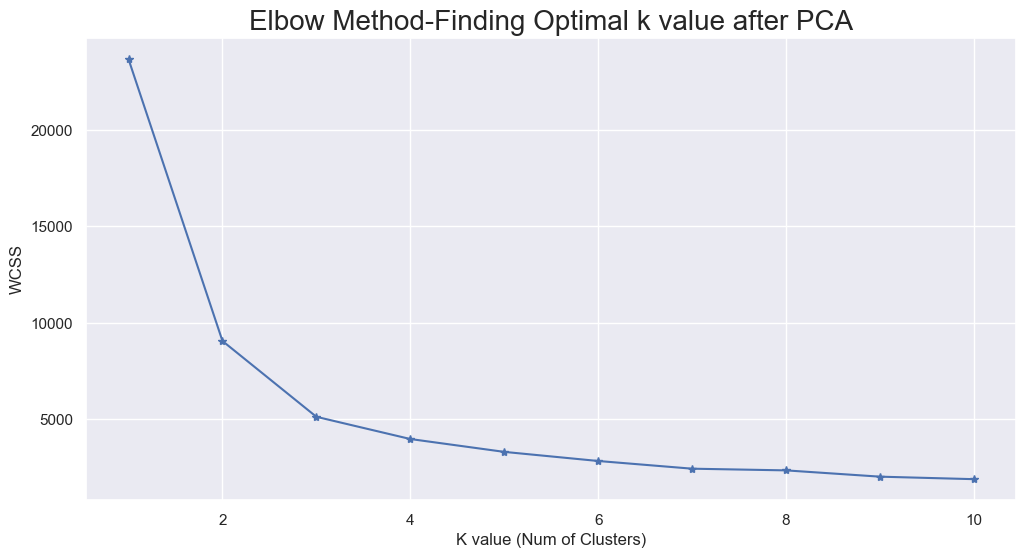

In [47]:
wcss = {}
plt.figure(figsize=(12,6))
for i in range(1,11): 
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(pcadf)
    wcss[i]=km.inertia_

plt.plot(range(1,11),wcss.values(), marker='*')
plt.title('Elbow Method-Finding Optimal k value after PCA', fontsize =20)
plt.xlabel('K value (Num of Clusters)')
plt.ylabel('WCSS')
plt.show()

- Here the optimum number of cluster is 3.
* We will use **k = 3**, thus there will be **three clusters** in our dataset.

#### Silhoutte Score Plot for K-Means to choose best number of clusters

For n_clusters = 2 The average silhouette_score is : 0.5284525824013865
For n_clusters = 3 The average silhouette_score is : 0.5103374738191572
For n_clusters = 4 The average silhouette_score is : 0.45367076647513765
For n_clusters = 5 The average silhouette_score is : 0.4288215321237218
For n_clusters = 6 The average silhouette_score is : 0.3993298122516977


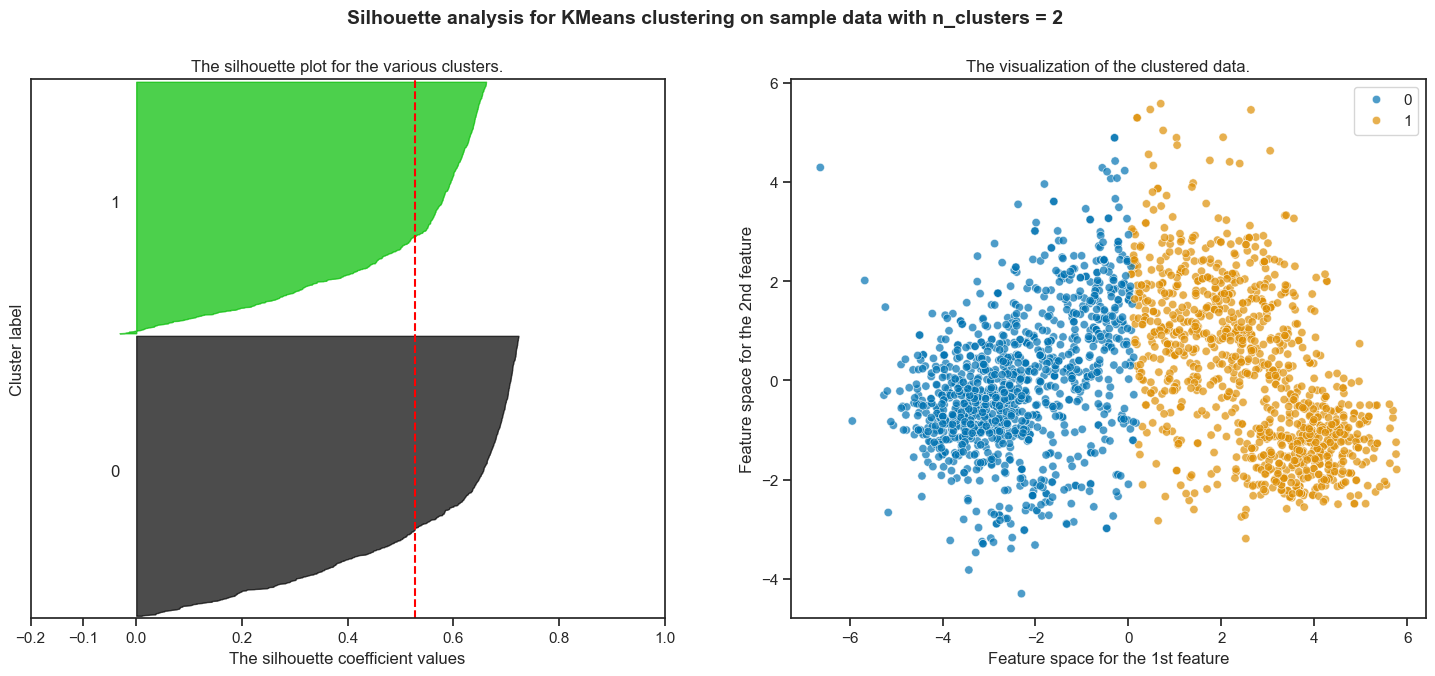

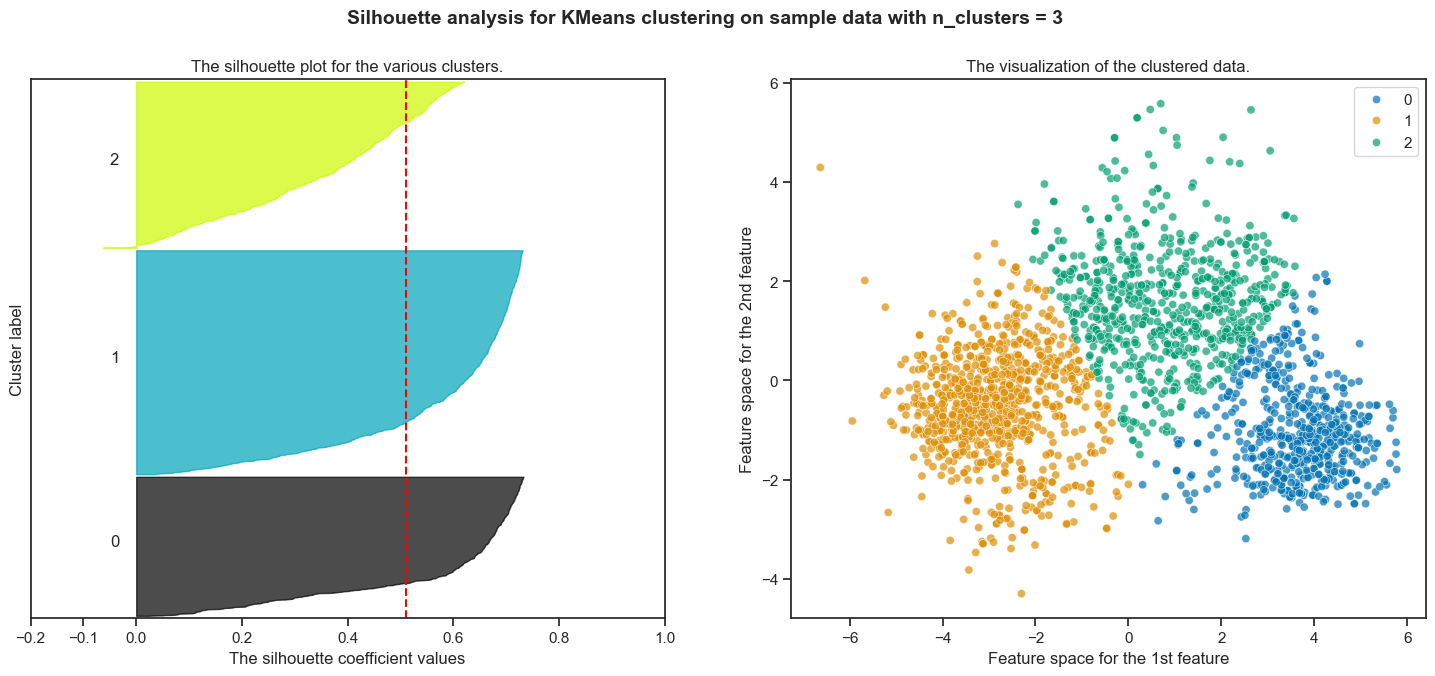

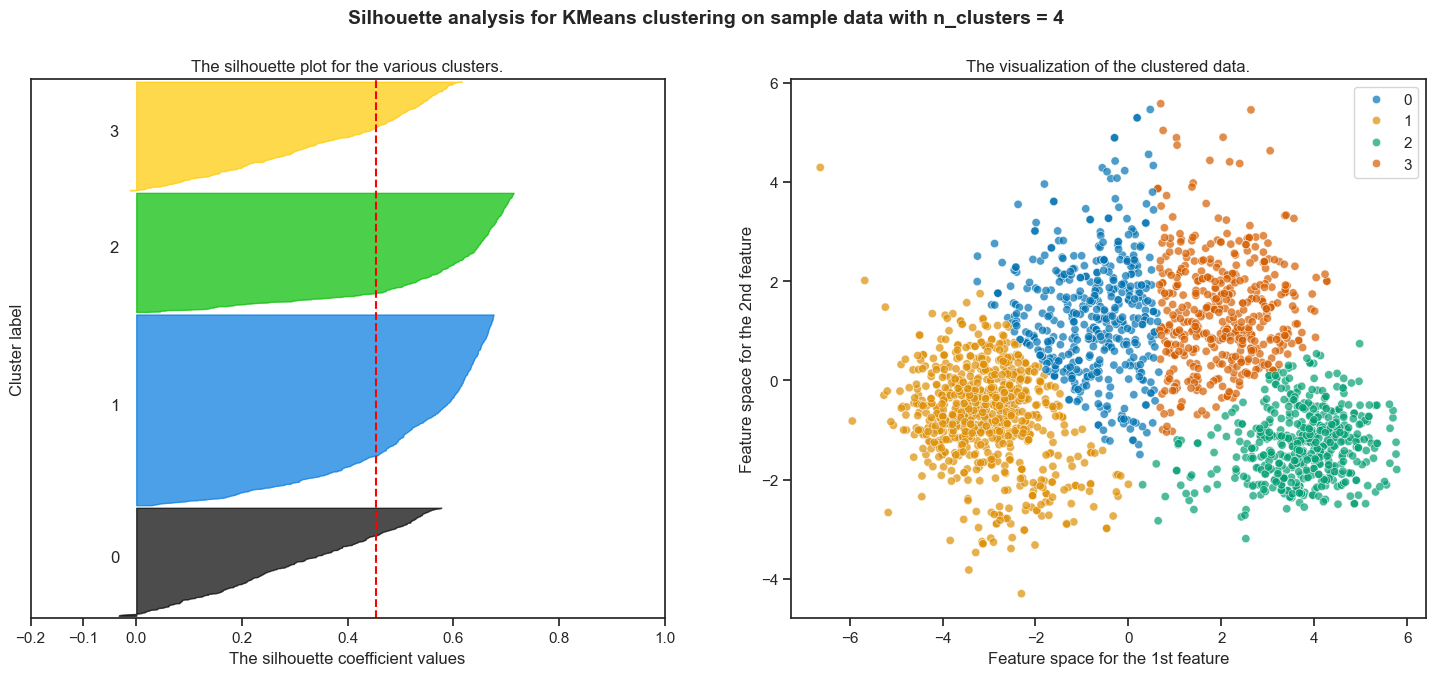

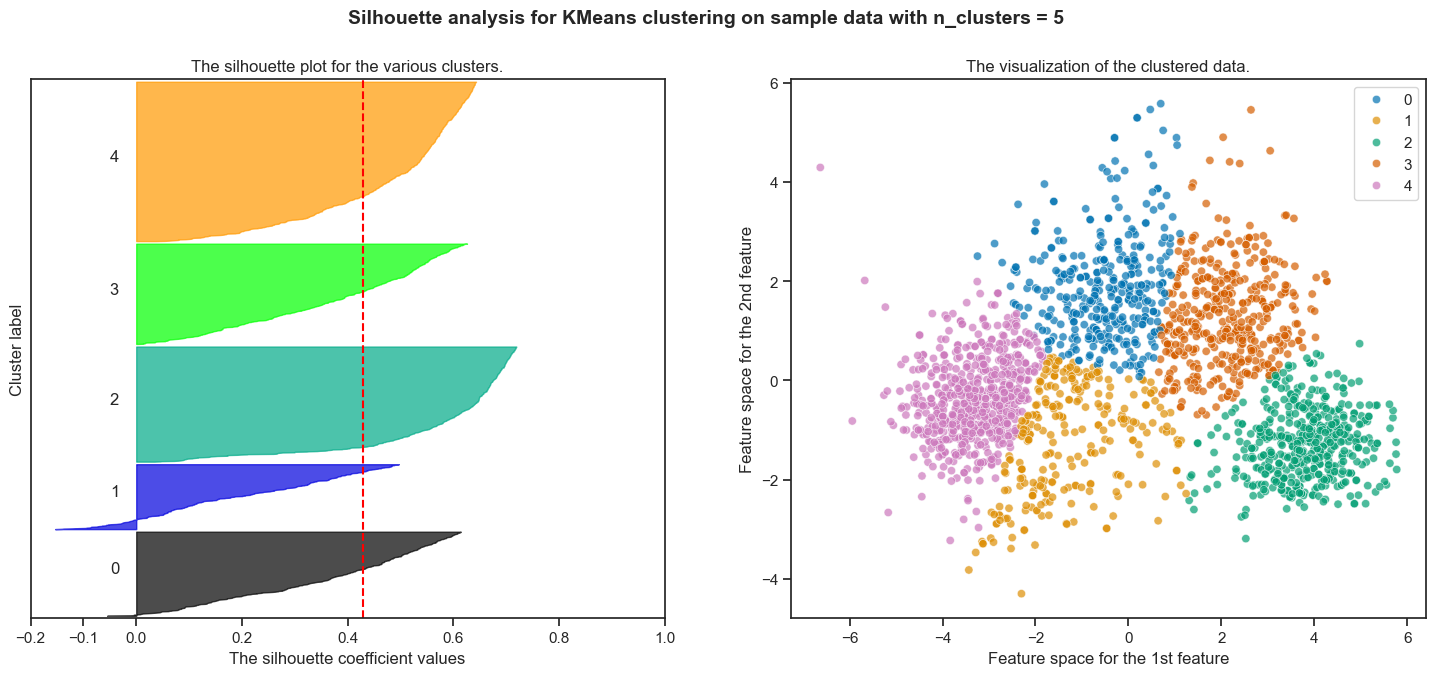

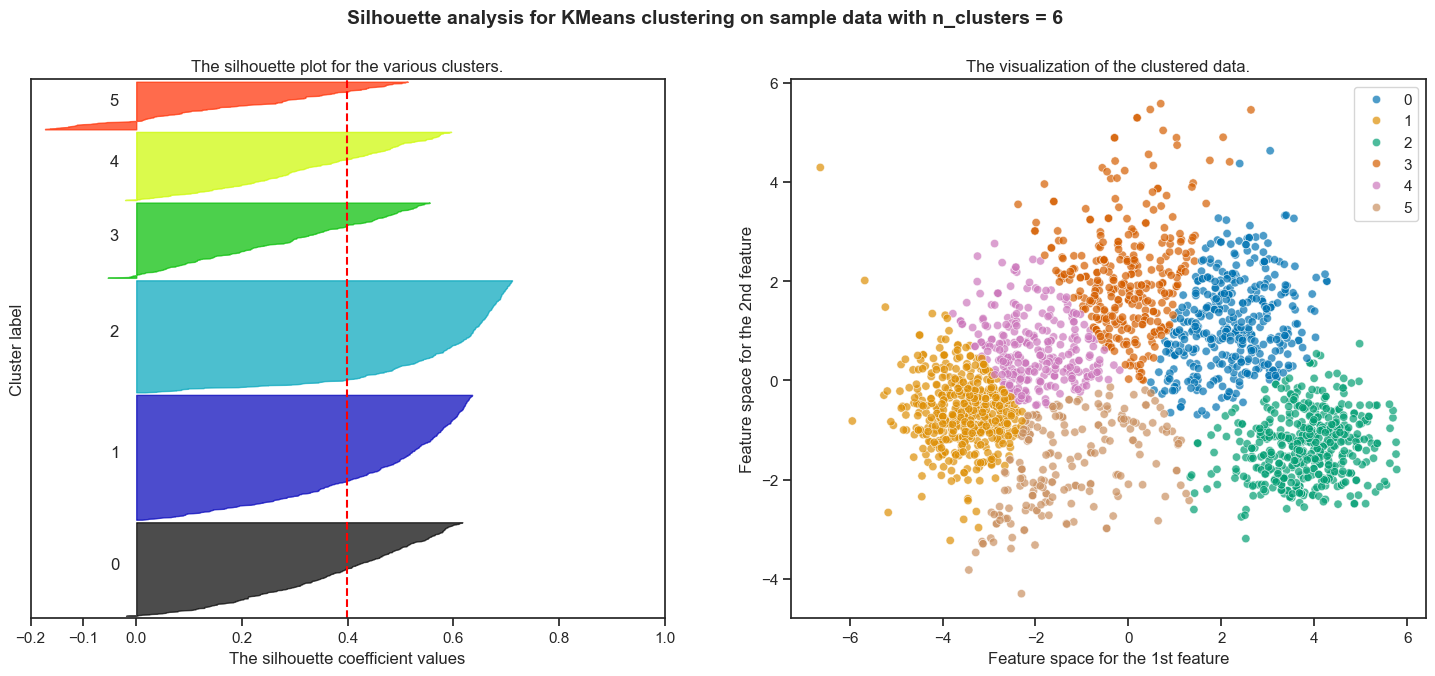

In [91]:
sns.set_style('ticks')
silhouette_plot(KMeans,range(2,7), pcadf, reduced)

* Clusters of 3 has good balance of Inertia and Shilloute score.

### Apply Kmeans Clustering with 3 clusters

In [50]:
# Fitting the model
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

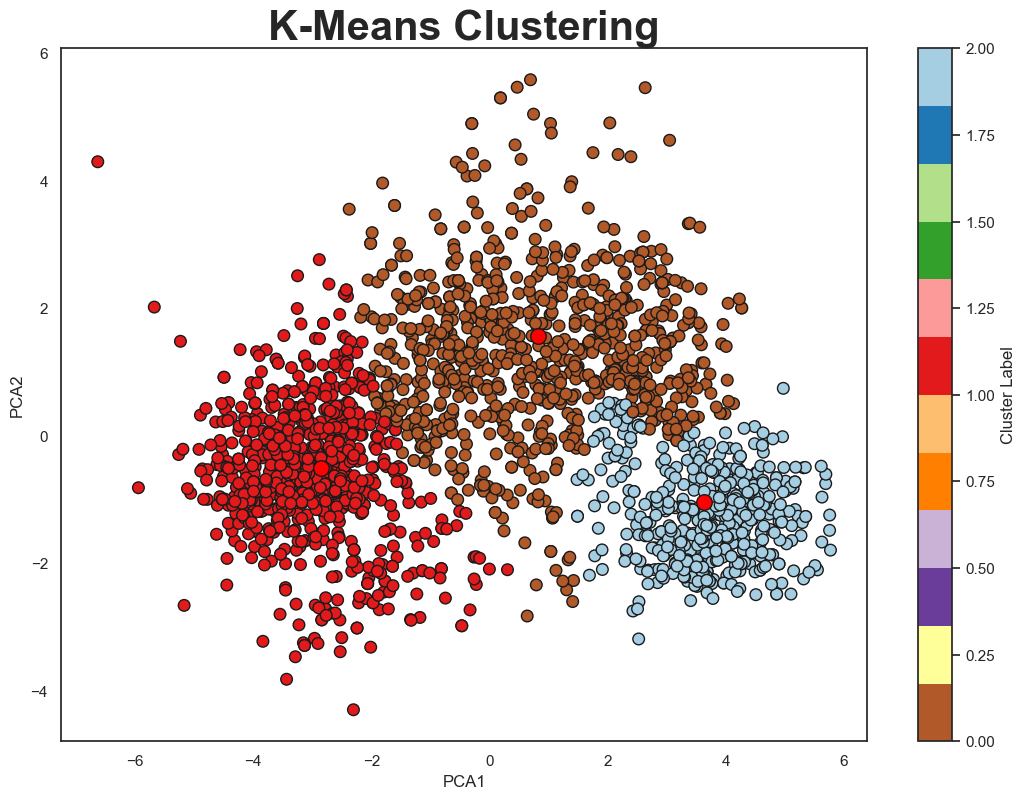

In [73]:
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter, label='Cluster Label')
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k')
plt.show()

# Agglomerative Clustering

#### Silhoutte Score Plot for Agglomerative clustering to choose best number of clusters

For n_clusters = 2 The average silhouette_score is : 0.4812381633383543
For n_clusters = 3 The average silhouette_score is : 0.4731768572652466
For n_clusters = 4 The average silhouette_score is : 0.43909314105485714
For n_clusters = 5 The average silhouette_score is : 0.4165380962734256
For n_clusters = 6 The average silhouette_score is : 0.393633382615838
For n_clusters = 7 The average silhouette_score is : 0.38969769334250987


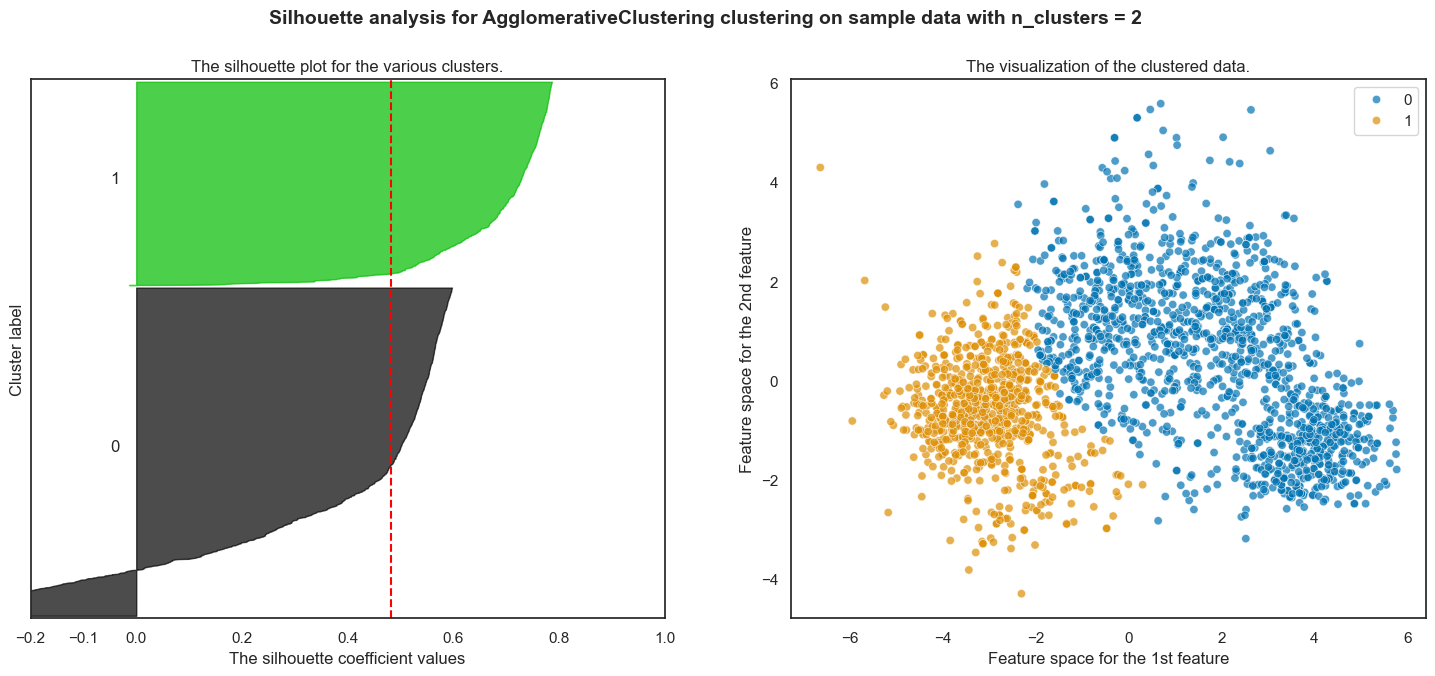

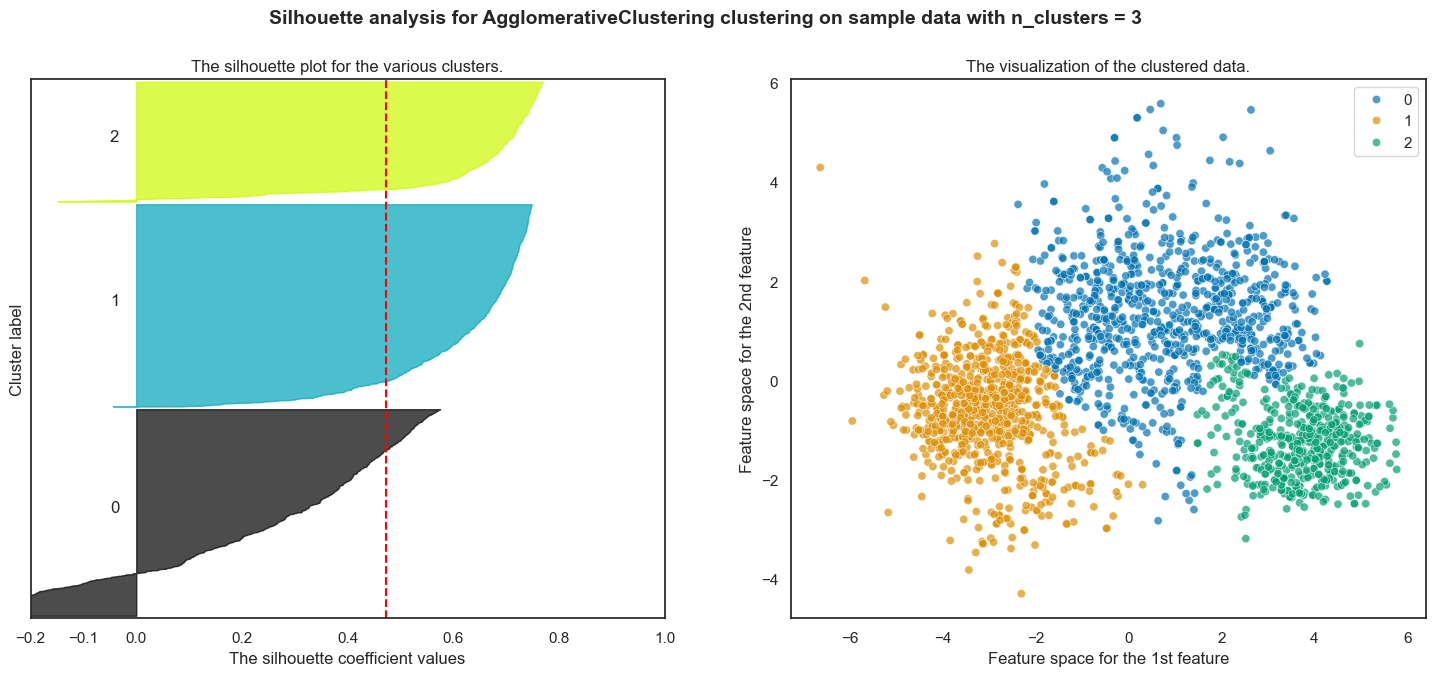

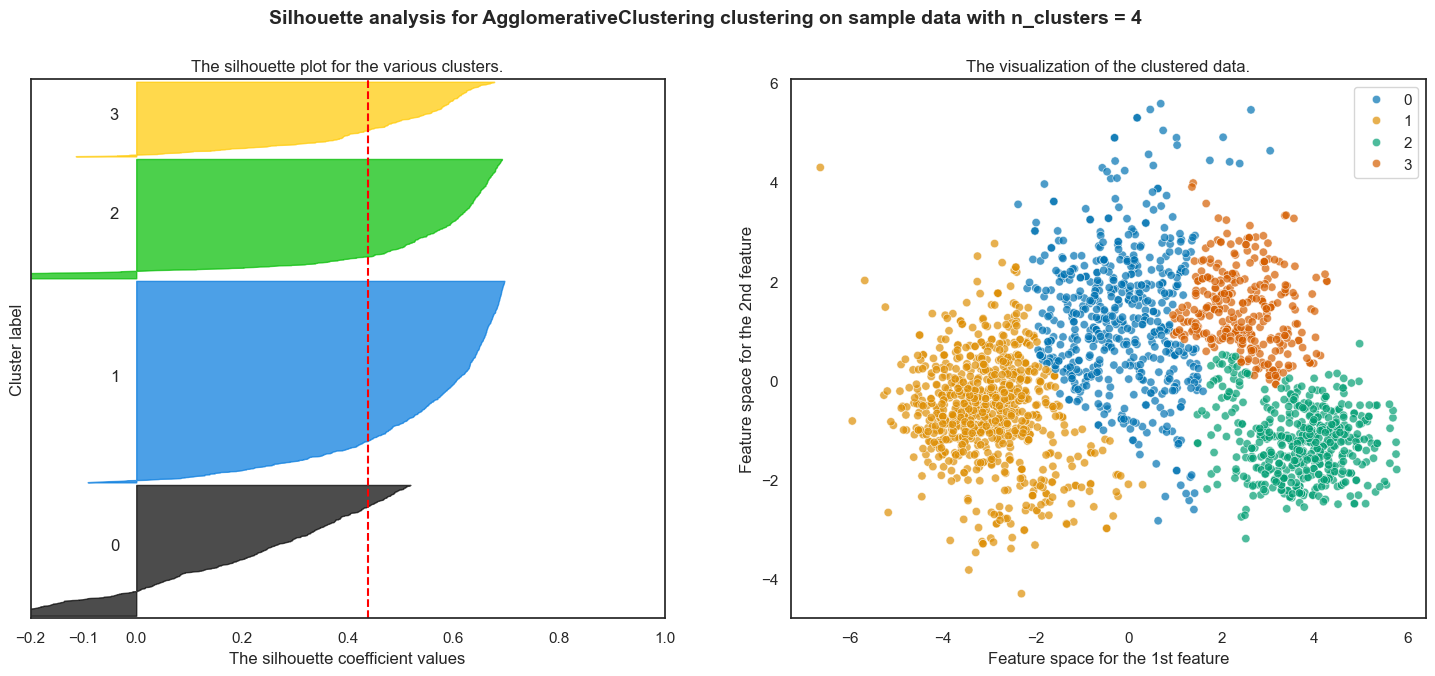

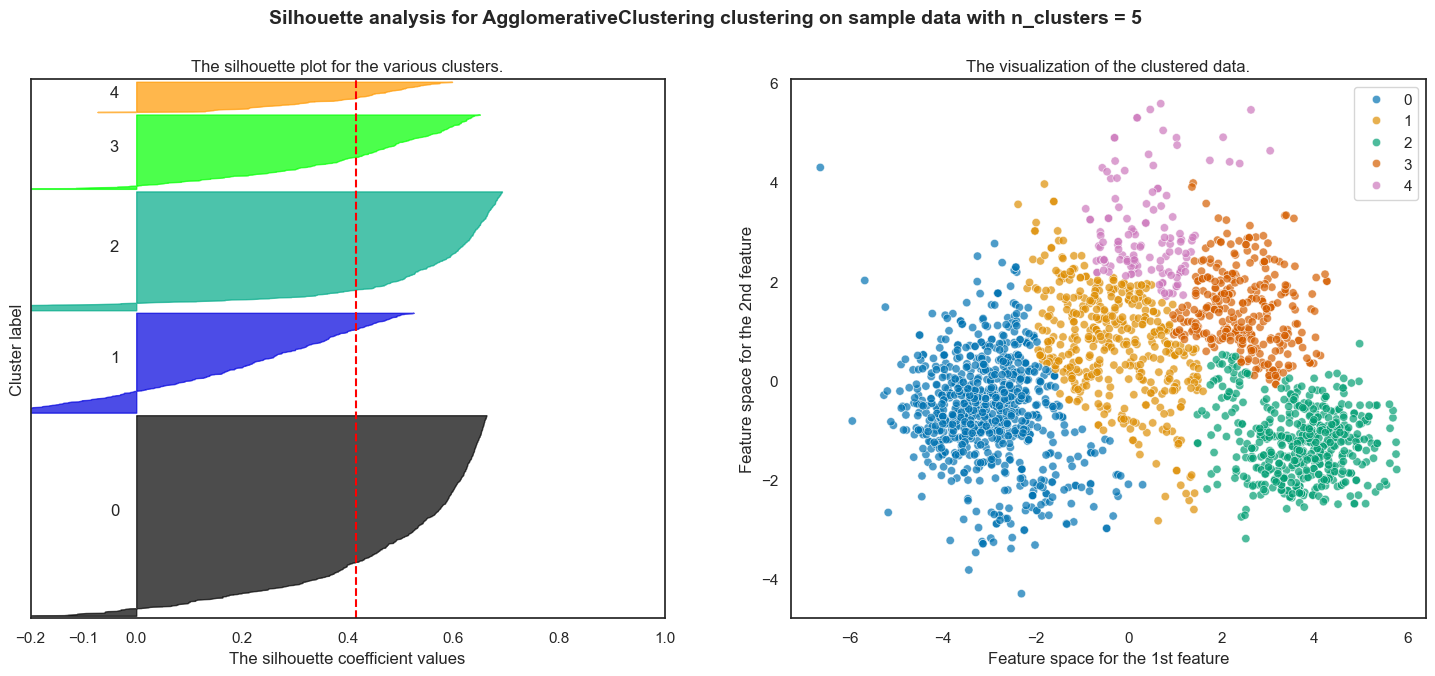

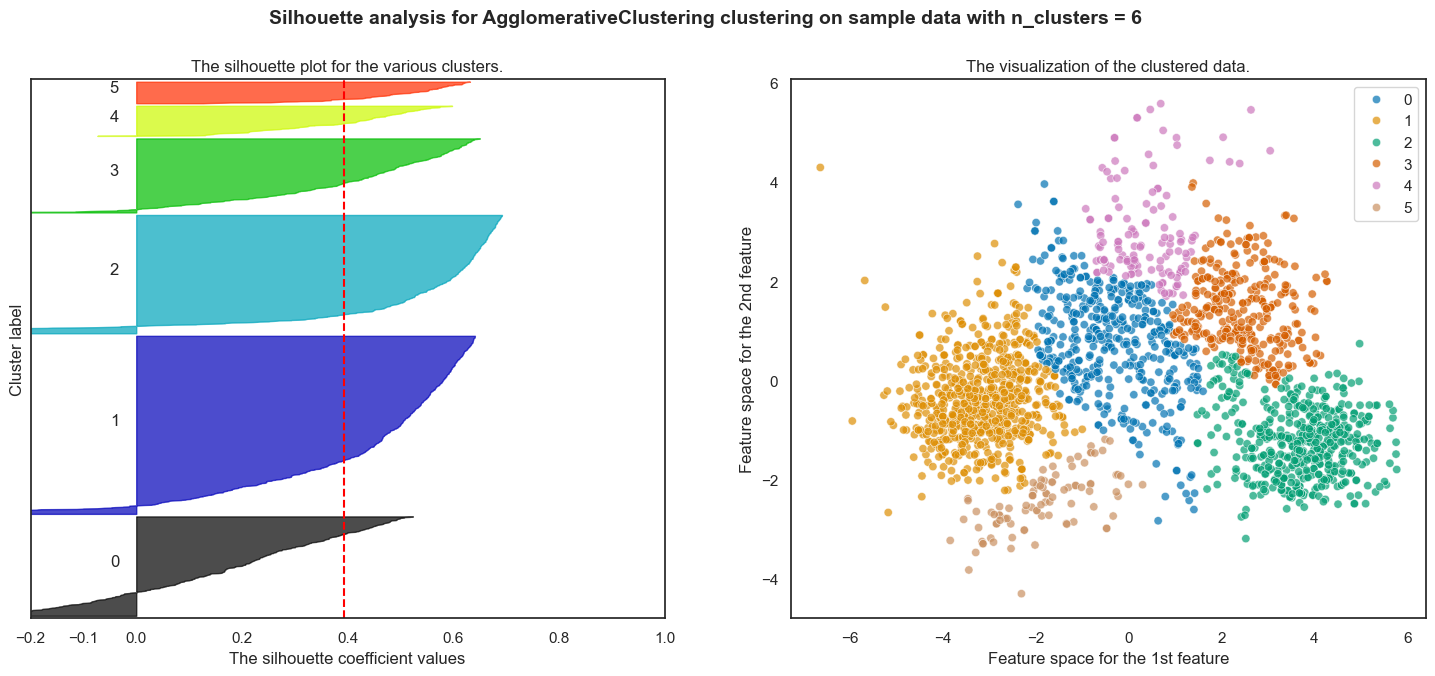

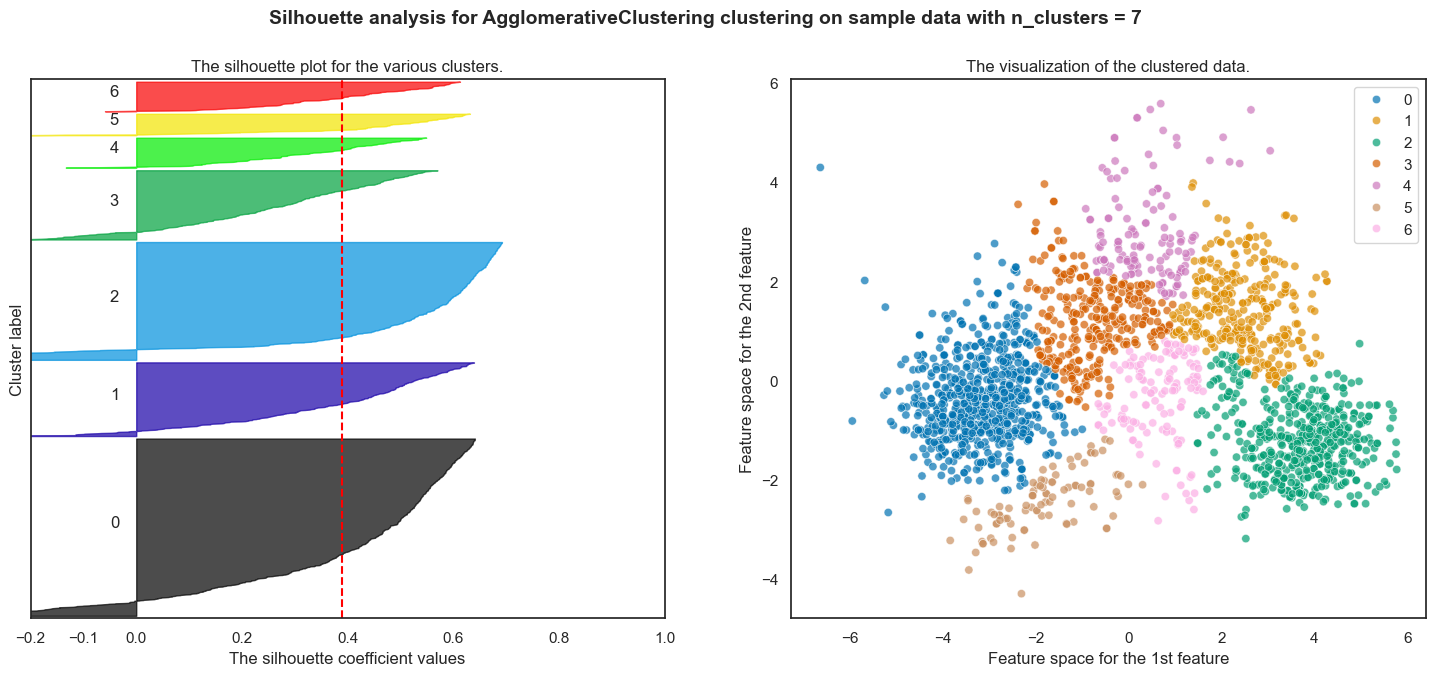

In [ ]:
# Plotting silhoutte score for Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
silhouette_plot(AgglomerativeClustering,range(2,8),pcadf,reduced)

* Clusters of 3 has good balance of Inertia and Shilloute score.

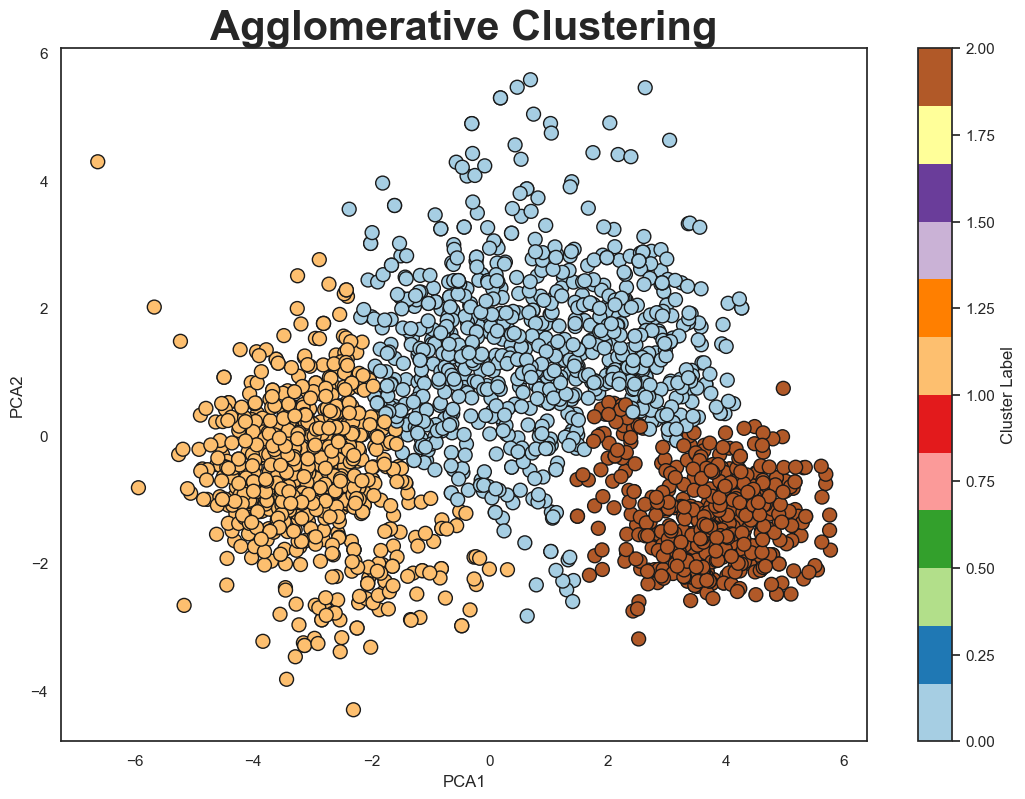

In [71]:
model = AgglomerativeClustering(n_clusters=3,metric='euclidean', linkage='ward').fit(reduced)
model_label = model.labels_
plt.figure(figsize=(13,9))

sns.set_style('white')
plt.title('Agglomerative Clustering', weight='bold', size=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=100, cmap='Paired', ec='k')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Gaussian Mixture

For n_clusters = 2 The average silhouette_score is : 0.5242555515493129
For n_clusters = 3 The average silhouette_score is : 0.4768345675456284
For n_clusters = 4 The average silhouette_score is : 0.44537732010936204
For n_clusters = 5 The average silhouette_score is : 0.4480830746181246
For n_clusters = 6 The average silhouette_score is : 0.4143512931088648
For n_clusters = 7 The average silhouette_score is : 0.29087183144517054


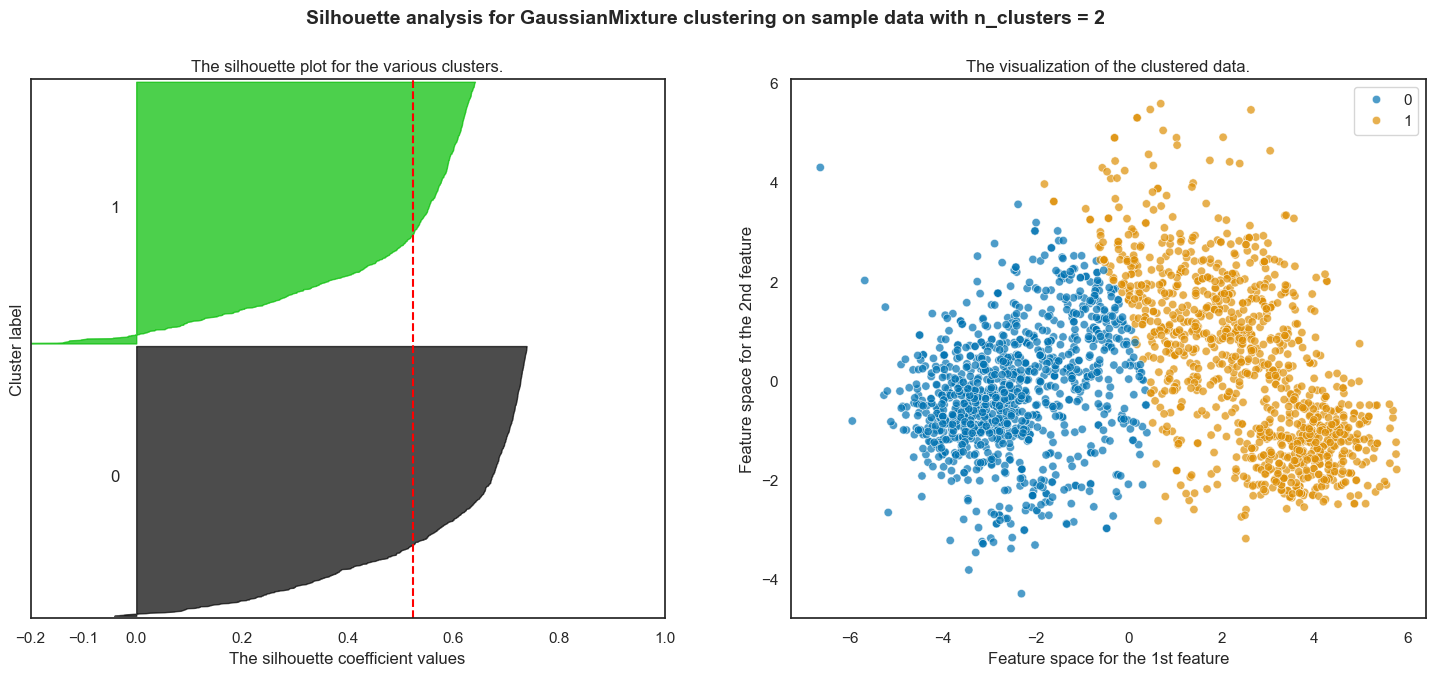

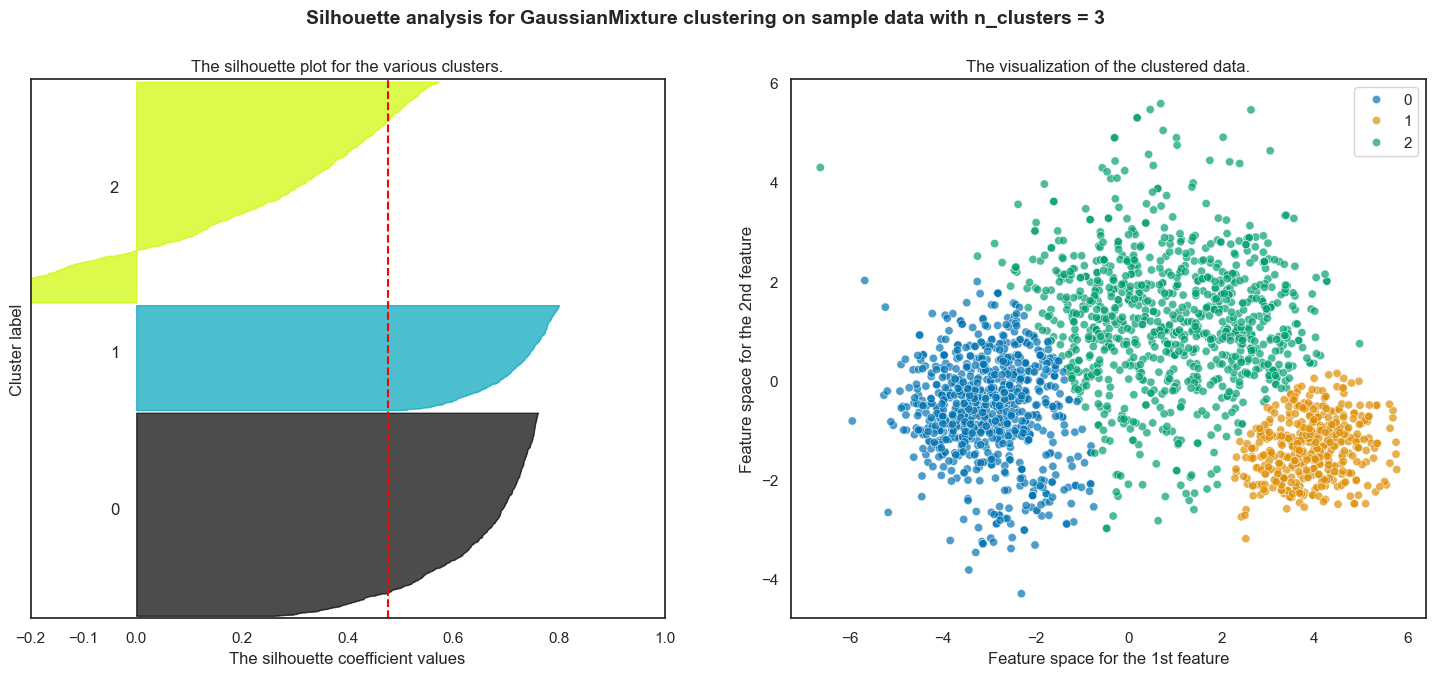

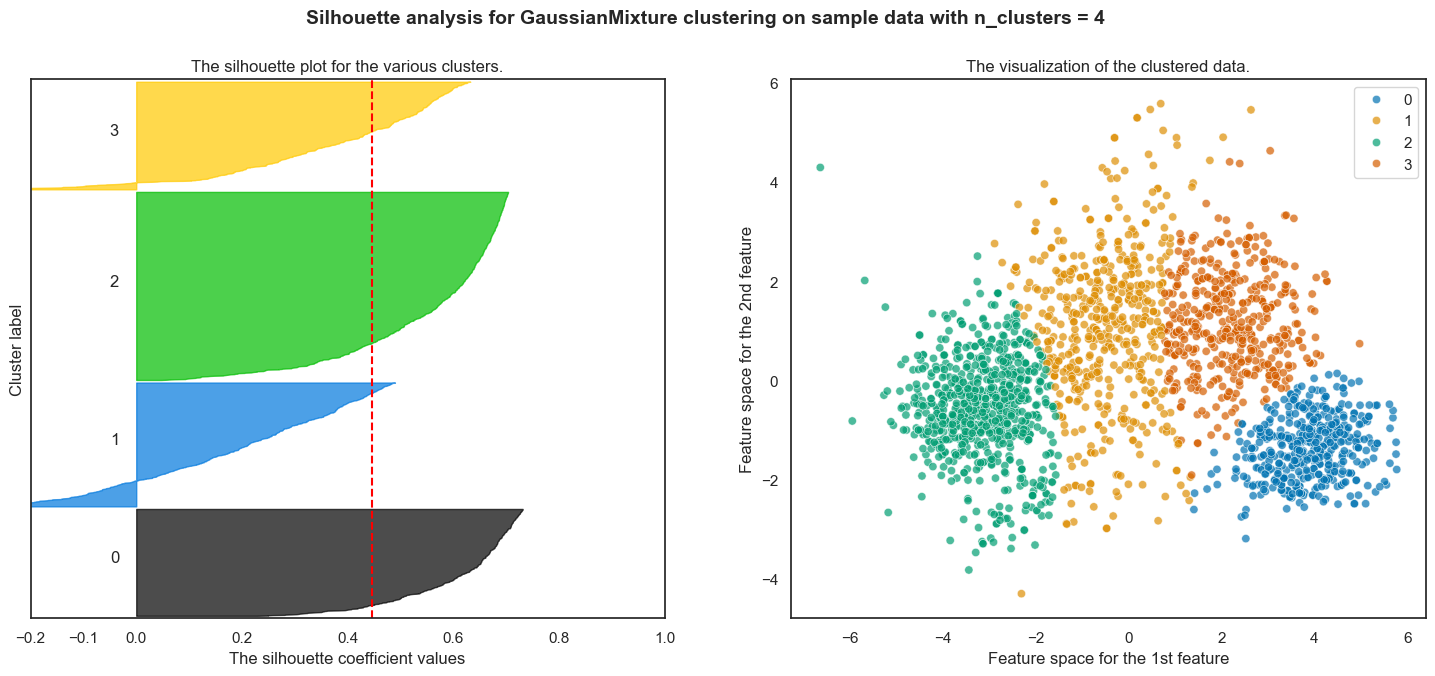

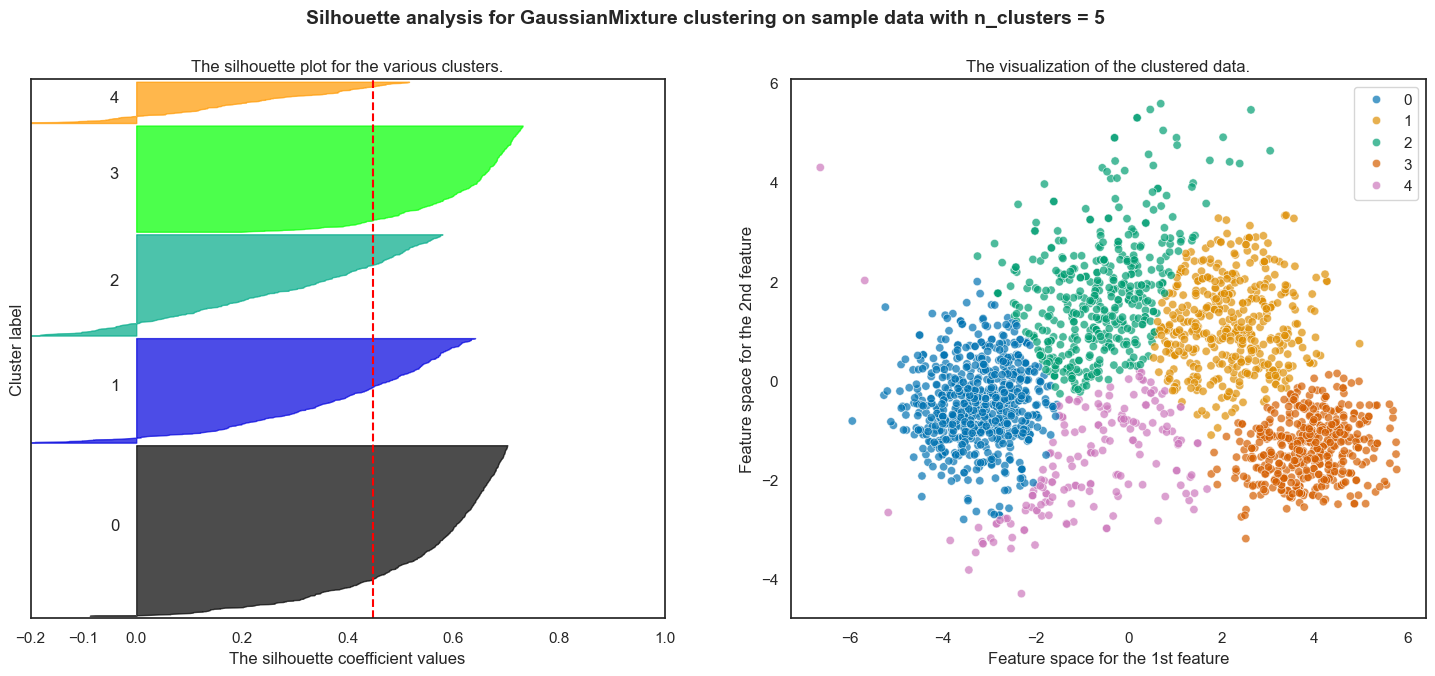

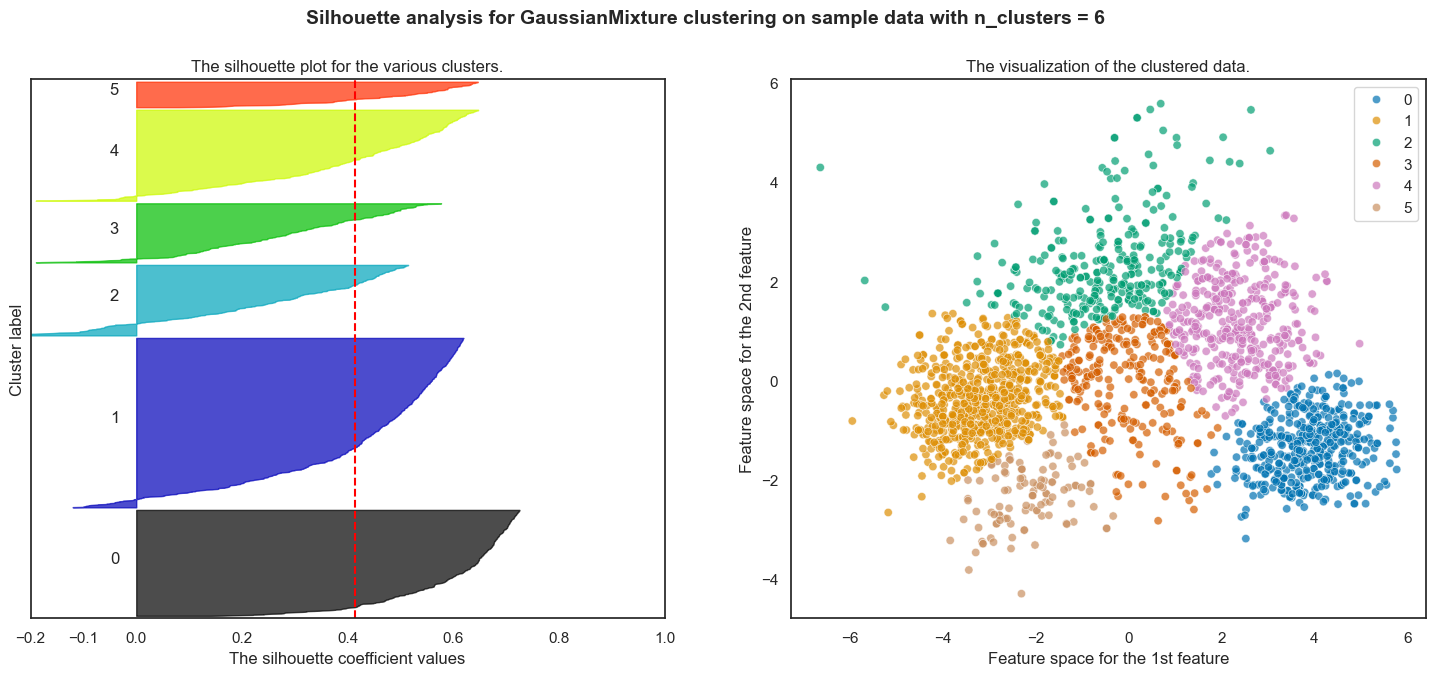

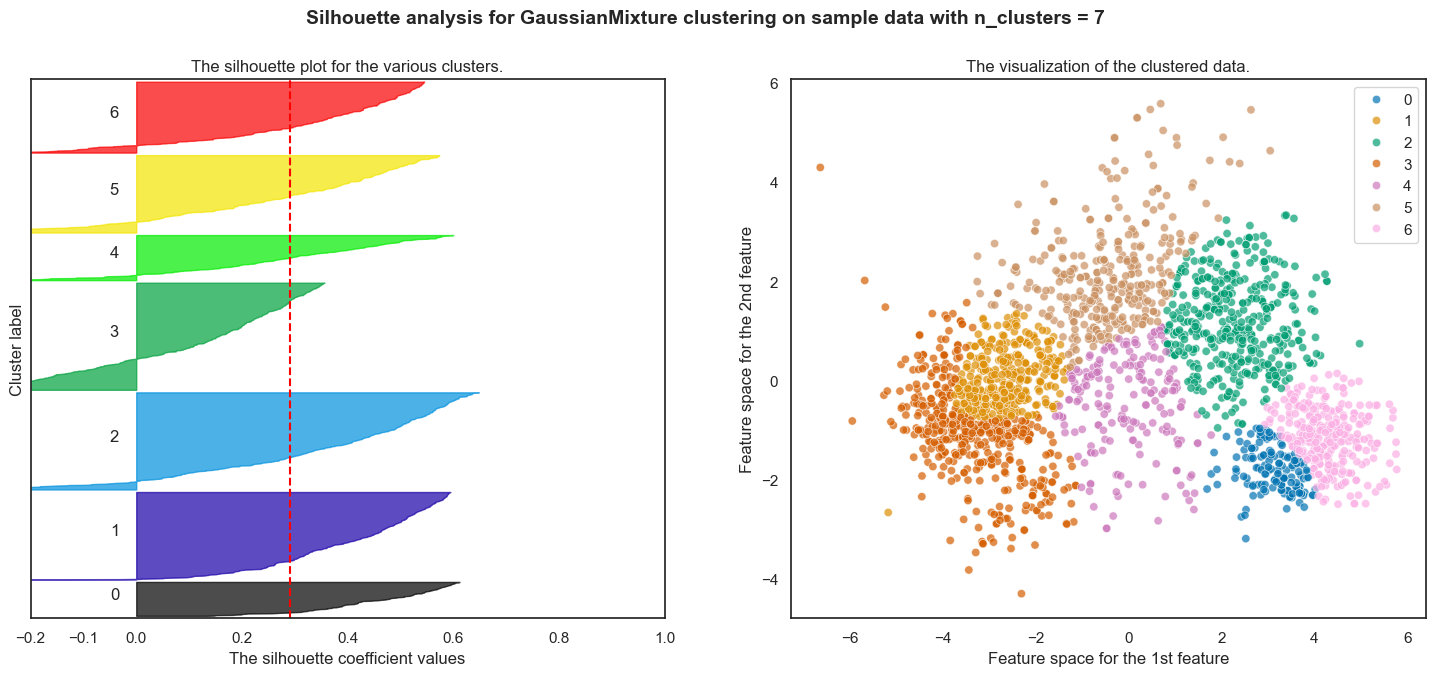

In [75]:
# Plotting silhoutte score for Gaussian score
from sklearn.mixture import GaussianMixture
silhouette_plot(GaussianMixture,range(2,8),pcadf,reduced)

* Clusters of 3 has good balance of Inertia and Shilloute score

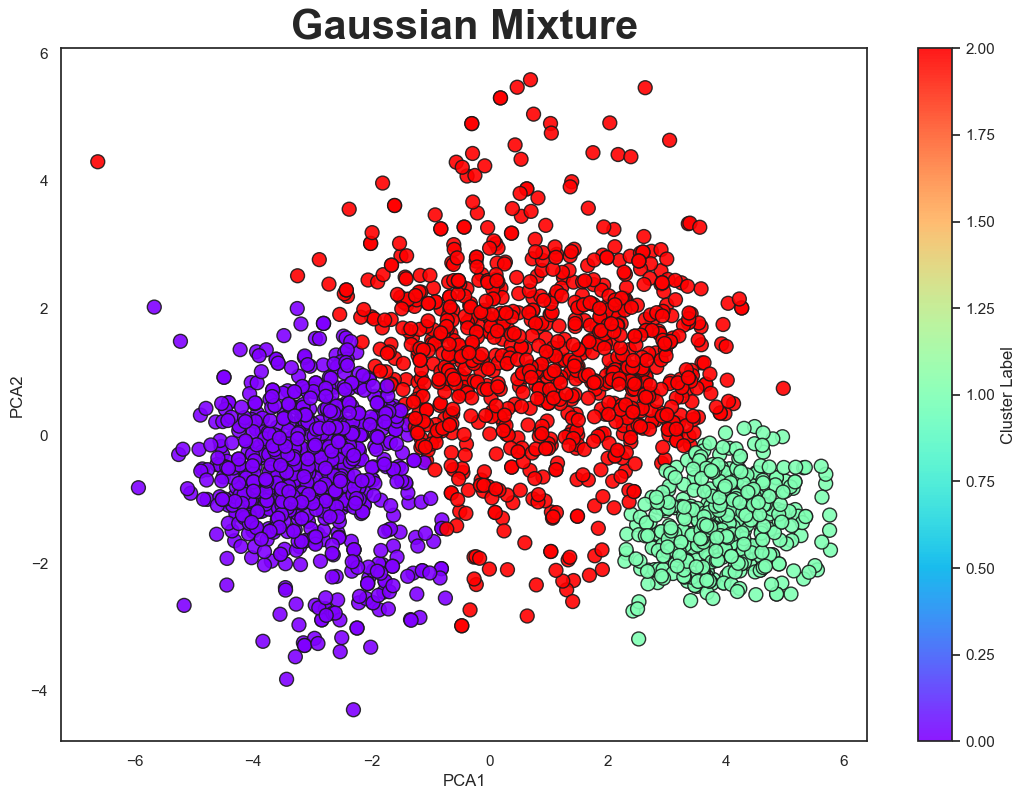

In [76]:
#plotting gaussian mixture with 3 clusters
model = GaussianMixture(n_components=3,random_state=42).fit(reduced)
model_label = model.predict(reduced)
plt.figure(figsize=(13,9))

sns.set_style('white')
plt.title('Gaussian Mixture', weight='bold', size=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=100, cmap='rainbow', ec='k', alpha=0.9)
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# DBSCAN Clustering

* `minPts` is the minimum number of data points that should be there in the region to define the cluster.
* A good reference point is to have $\text{minPts} \geq D+1$ where D is the dimension of the dataset.

### Finding the Optimal value of Epsilon

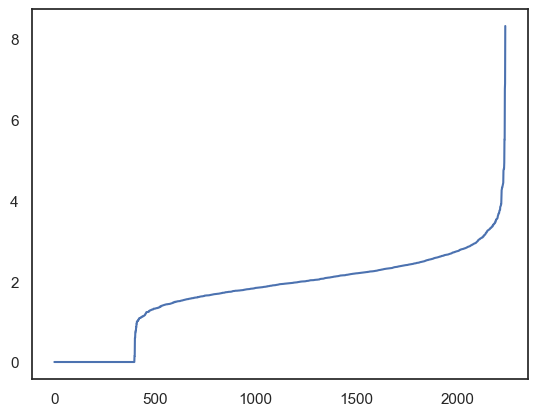

In [80]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

neighbors = NearestNeighbors(n_neighbors=22)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)

distances = distances[:,1]
plt.plot(distances)
plt.show()

<Figure size 500x500 with 0 Axes>

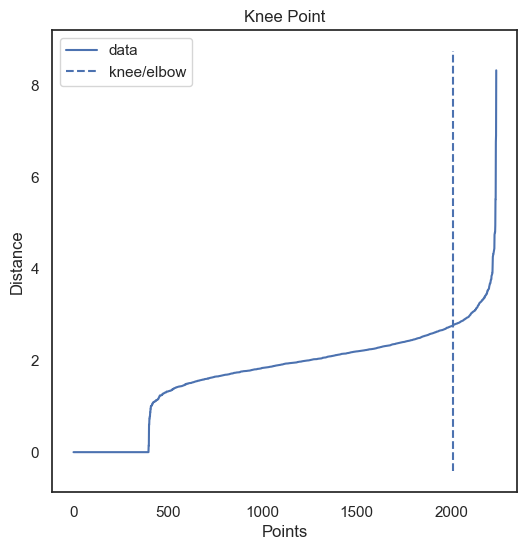

Knee Locator k = 2.7562617466852317


In [ ]:
#!pip install kneed
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k = distances[knee.knee]
print(f'Knee Locator k = {k}')

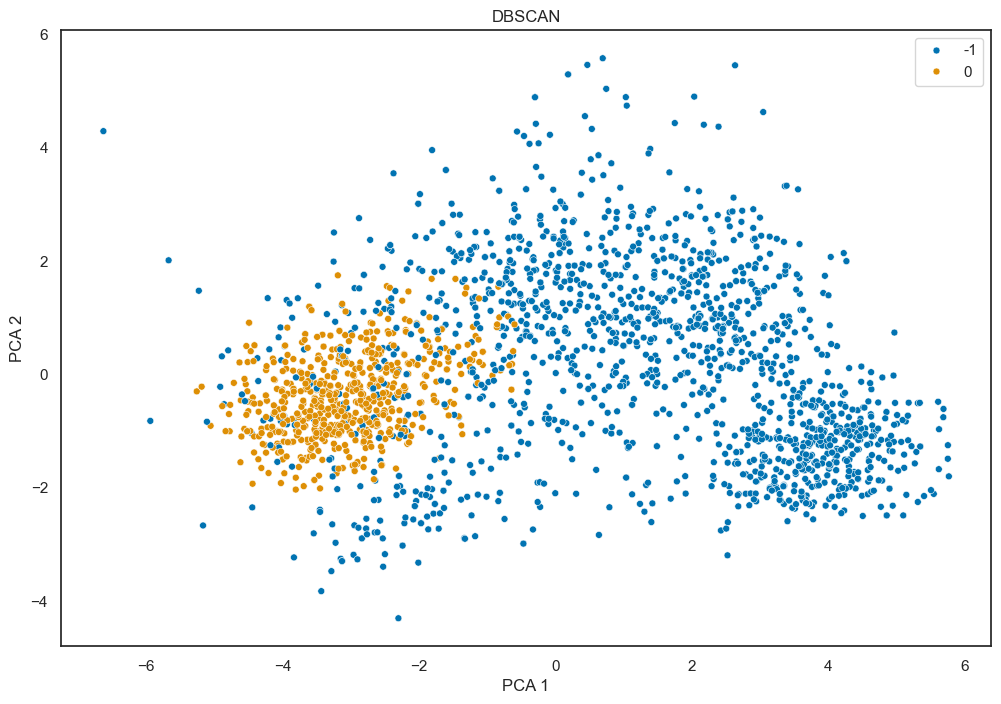

In [90]:
model=DBSCAN(eps = k , min_samples = 100).fit(df_scaled)
model_label = model.labels_
plt.figure(figsize=(12,8))

plt.title('DBSCAN')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
scatter = sns.scatterplot(x = reduced[:,0], y = reduced[:,1], hue= model_label, palette=sns.color_palette("colorblind", len(set(model_label))), s=25)
plt.show()

### Final Model

K-means clustering performed well than rest of the other algorithms.

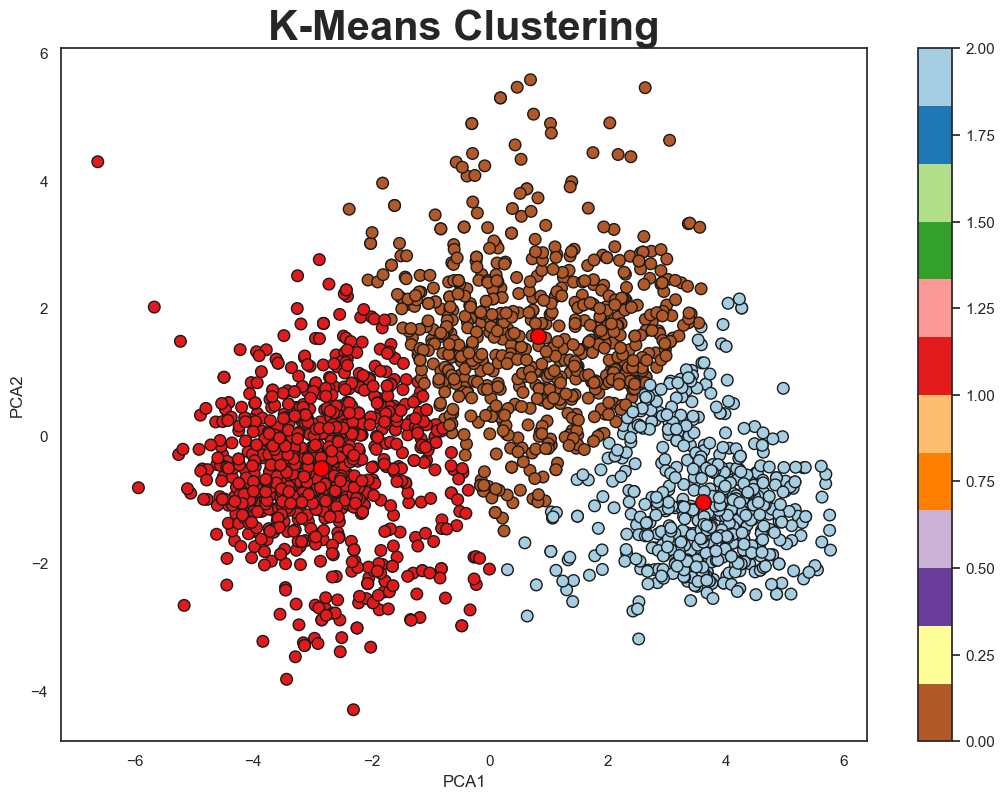

In [88]:
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k')
plt.show()

### Saving the data with cluster column

In [89]:
#save model labels as new feature
import os
df["cluster"] = model.labels_.astype(int)
os.makedirs('data')
df.to_csv("./data/clustered_data.csv", index=False)

### Final report
- As we got the EDA results, we used that same approaches here also. We extracted out some features to derive valuable meanings from the data and used those in model training.
- The data had outliers and multicollinearity, We created pipelines to handle those things.
- Used PCA to minimize the dimensionality of the data.
- K-means Clustering algorithm has performed better then rest of the other clustering algorithms.